In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
data = pd.read_csv('customer_data.csv');

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
#Cleaning of Data
#% of missing values

df_null = round(100*(data.isnull().sum())/len(data), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
#Droping the rows which are having missing values
data = data.dropna()

In [8]:
data.shape

(406829, 8)

In [9]:
#Changing datatype of CustomerID from float to str
data['CustomerID'] = data['CustomerID'].astype(str)

In [10]:
#Monetary

data['Amount'] = data['Quantity']*data['UnitPrice']
mt_rfm = data.groupby('CustomerID')['Amount'].sum()
mt_rfm = mt_rfm.reset_index()
mt_rfm.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [11]:
#Frequency

f_rfm = data.groupby('CustomerID')['InvoiceNo'].count()
f_rfm = f_rfm.reset_index()
f_rfm.columns = ['CustomerID','Frequency']
f_rfm.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [12]:
#Merge the two dataframes (df) of Monetary and Frequency
rfm = pd.merge(mt_rfm, f_rfm , on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [13]:
#Recency
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

date_max = max(data['InvoiceDate'])
date_max

Timestamp('2011-12-09 12:50:00')

In [14]:
data['Difference'] = date_max - data['InvoiceDate']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Difference
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
#Computing recency of Customer

r_rfm = data.groupby('CustomerID')['Difference'].min()
r_rfm = r_rfm.reset_index()
r_rfm.head()

,CustomerID,Difference
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [16]:
#Keep only n0. of Days

r_rfm['Difference'] = r_rfm['Difference'].dt.days
r_rfm.head()

,CustomerID,Difference
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [17]:
#Final Dataframe(df)

rfm = pd.merge(rfm, r_rfm, on='CustomerID', how='inner')
rfm.columns = ['CustomerID' , 'Amount' , 'Frequency' , 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

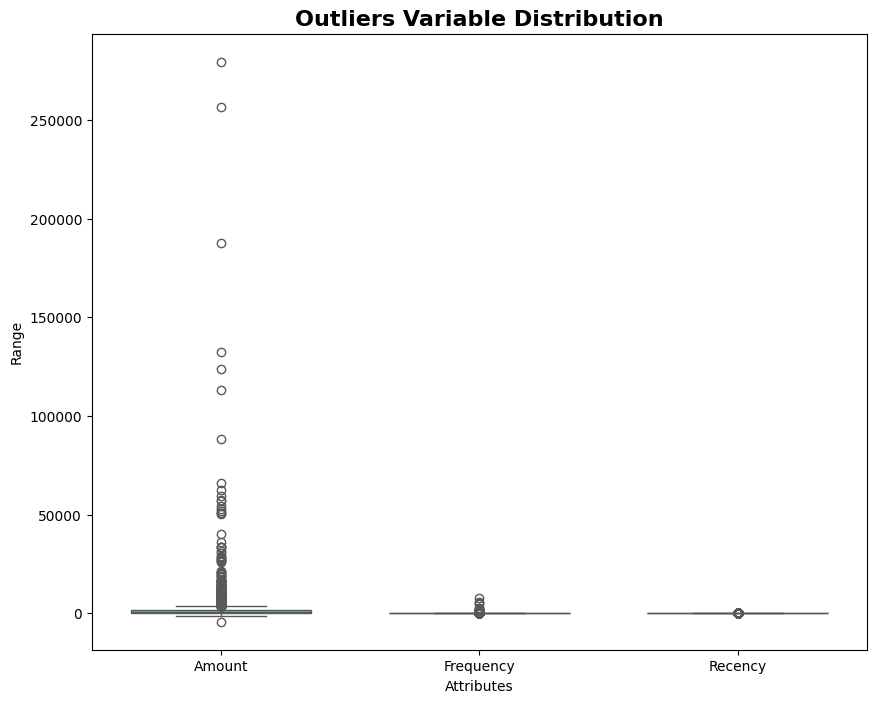

In [18]:
#Outliers Analysis of RFM

attributes = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 16, fontweight = 'bold')
plt.ylabel("Range") 
plt.xlabel("Attributes")


In [19]:
# Removing outliers

#Amount
Q1 = rfm.Amount.quantile(0.05)
Q2 = rfm.Amount.quantile(0.95)

IQR = Q2 - Q1
rfm= rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q2 + 1.5*IQR)]

#Recency
Q1 = rfm.Recency.quantile(0.05)
Q2 = rfm.Recency.quantile(0.95)

IQR = Q2 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q2 + 1.5*IQR)]

#Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q2 = rfm.Frequency.quantile(0.95)

IQR = Q2 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q2 + 1.5*IQR)]

In [20]:
#Scaling of the Features

df_rfm = rfm[['Amount','Frequency','Recency']]

scaler = StandardScaler()

#Fit Transform
df_rfm_scaled = scaler.fit_transform(df_rfm)
df_rfm_scaled.shape

(4293, 3)

In [21]:
df_rfm_scaled = pd.DataFrame(df_rfm_scaled)
df_rfm_scaled.columns = ['Amount', 'Frequency', 'Recency']

In [22]:
#MODEL BUILDING
#k-means

kmeans = KMeans(n_clusters = 4, max_iter = 50)
kmeans.fit(df_rfm_scaled)

KMeans(max_iter=50, n_clusters=4)

In [23]:
#labelling
kmeans.labels_
set(kmeans.labels_)

{0, 1, 2, 3}

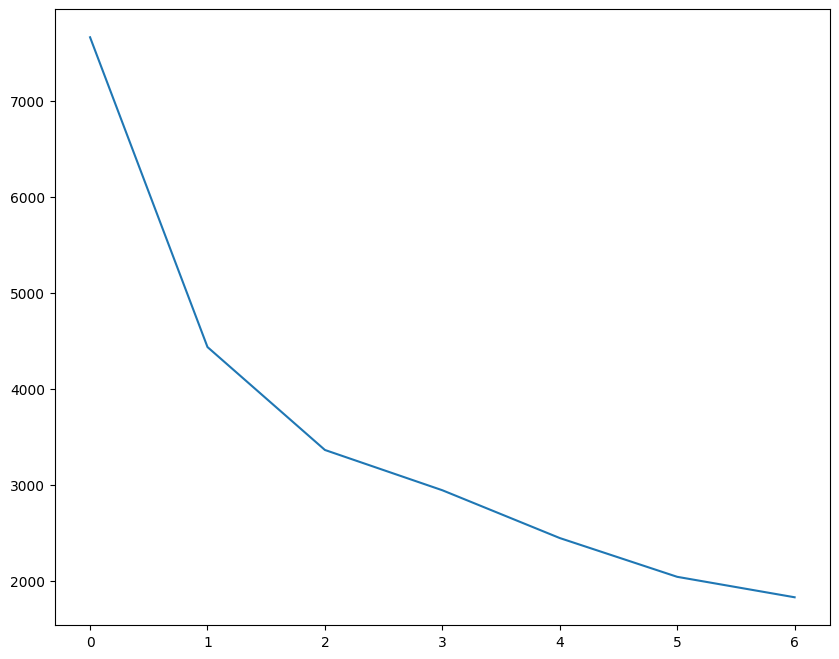

In [24]:
sd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters: 
    kmeans = KMeans(n_clusters = num_clusters, max_iter=50) 
    kmeans.fit(df_rfm_scaled)

    sd.append(kmeans.inertia_)

# plot the SDs for each n_clusters 
plt.plot(sd)

In [25]:
#Final Kmeans Model with value k=3
kmeans = KMeans(n_clusters = 3, max_iter = 300)
kmeans.fit(df_rfm_scaled)

KMeans(n_clusters=3)

In [26]:
#Creating Pickle file
import pickle

filename = 'FinalYear_Project.pk1'

with open('kmeans_model','wb') as file:
    pickle.dump(kmeans, file)
    
file.close()

pickle.dump(kmeans, open('FinalYear_Project.pk1','wb'))



In [27]:
kmeans.labels_

array([1, 2, 0, ..., 1, 0, 0])

In [28]:
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

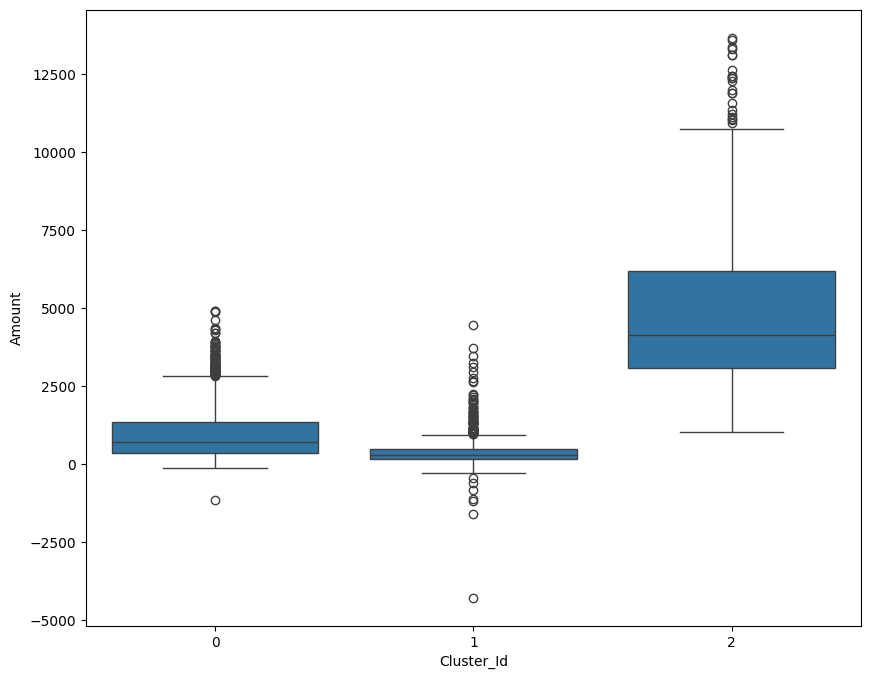

In [29]:
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

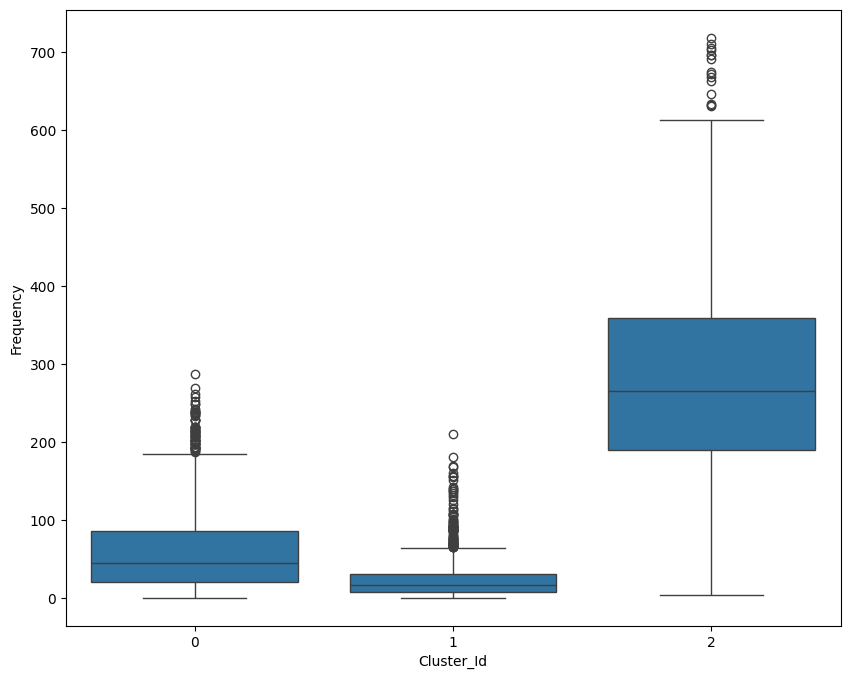

In [30]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

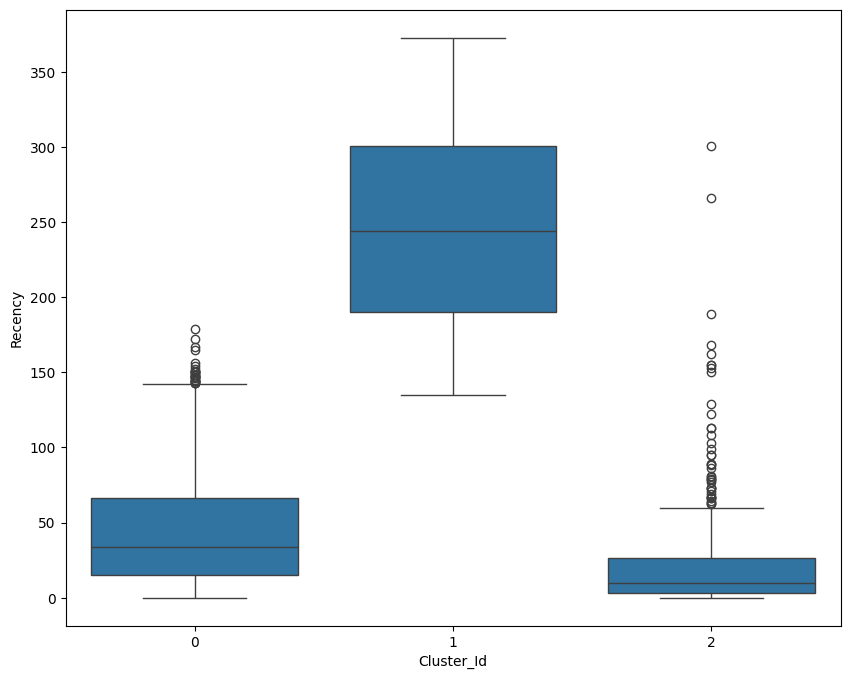

In [31]:
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

In [32]:
import joblib


In [33]:
joblib.dump(kmeans, 'Customer Segmentation')

['Customer Segmentation']

In [34]:
model= joblib.load('Customer Segmentation')

Data loaded successfully.


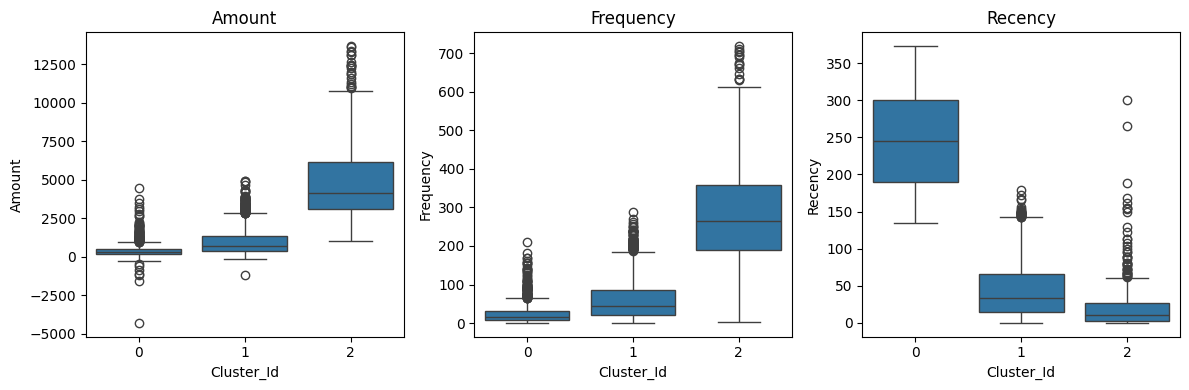

In [36]:
import tkinter as tk
from tkinter import filedialog
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib

class CustomerSegmentationApp:
    def __init__(self, master):
        self.master = master
        master.title("Customer Segmentation App")

        self.load_data_button = tk.Button(master, text="Load Data", command=self.load_data)
        self.load_data_button.pack()

        self.segment_button = tk.Button(master, text="Segment Customers", command=self.segment_customers)
        self.segment_button.pack()

    def load_data(self):
        self.data_filename = filedialog.askopenfilename(initialdir="/", title="Select file",
                                                         filetypes=(("CSV files", "*.csv"), ("all files", "*.*")))
        self.data = pd.read_csv(self.data_filename)
        print("Data loaded successfully.")

    def segment_customers(self):
        if not hasattr(self, 'data'):
            print("Please load data first.")
            return

        data = self.data.copy()

        data['Amount'] = data['Quantity']*data['UnitPrice']

        mt_rfm = data.groupby('CustomerID')['Amount'].sum().reset_index()
        f_rfm = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()
        f_rfm.columns = ['CustomerID','Frequency']
        rfm = pd.merge(mt_rfm, f_rfm, on='CustomerID', how='inner')

        data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
        date_max = max(data['InvoiceDate'])
        data['Difference'] = date_max - data['InvoiceDate']
        r_rfm = data.groupby('CustomerID')['Difference'].min().reset_index()
        r_rfm['Difference'] = r_rfm['Difference'].dt.days
        rfm = pd.merge(rfm, r_rfm, on='CustomerID', how='inner')
        rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']

        # Removing outliers
        Q1 = rfm.Amount.quantile(0.05)
        Q2 = rfm.Amount.quantile(0.95)
        IQR = Q2 - Q1
        rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q2 + 1.5*IQR)]

        Q1 = rfm.Recency.quantile(0.05)
        Q2 = rfm.Recency.quantile(0.95)
        IQR = Q2 - Q1
        rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q2 + 1.5*IQR)]

        Q1 = rfm.Frequency.quantile(0.05)
        Q2 = rfm.Frequency.quantile(0.95)
        IQR = Q2 - Q1
        rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q2 + 1.5*IQR)]

        df_rfm = rfm[['Amount','Frequency','Recency']]
        scaler = StandardScaler()
        df_rfm_scaled = scaler.fit_transform(df_rfm)

        kmeans = KMeans(n_clusters = 3, max_iter = 300)
        kmeans.fit(df_rfm_scaled)
        rfm['Cluster_Id'] = kmeans.labels_

        self.plot_graphs(rfm)

    def plot_graphs(self, rfm):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)
        plt.title('Amount')

        plt.subplot(1, 3, 2)
        sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)
        plt.title('Frequency')

        plt.subplot(1, 3, 3)
        sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)
        plt.title('Recency')

        plt.tight_layout()
        plt.show()

root = tk.Tk()
app = CustomerSegmentationApp(root)
root.mainloop()
